In [2]:
import random
from collections import deque

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
import torch
import torch.nn as nn

class DQN(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [4]:
import torch.optim as optim

class DQNAgent:
    def __init__(self, env, input_dim, action_dim, memory_size=10000, batch_size=64, gamma=0.99, lr=1e-3, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=500):
        self.env = env
        self.action_dim = action_dim
        self.memory = ReplayMemory(memory_size)
        self.batch_size = batch_size
        self.gamma = gamma

        self.epsilon = epsilon_start #epsilon
        self.epsilon_min = epsilon_end
        self.epsilon_decay = epsilon_decay

        self.q_network = DQN(input_dim, action_dim).to(device) #Q network and target network
        self.target_network = DQN(input_dim, action_dim).to(device)
        self.update_target_network()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.action_dim)
        else:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                return self.q_network(state).argmax().item()

    def train_step(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.q_network(states).gather(1, actions) #current state Q vaues

        next_q_values = self.target_network(next_states).max(1, keepdim=True)[0]  #next state Q values dervied from target network
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = F.mse_loss(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * np.exp(-1.0 / self.epsilon_decay))

    def save(self, filename):
        torch.save(self.q_network.state_dict(), filename)

    def load(self, filename):
        self.q_network.load_state_dict(torch.load(filename))
        self.update_target_network()

In [5]:
!pip install gymnasium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 10.0 MB/s eta 0:00:00


In [6]:
import gymnasium as gym
from gym import spaces
import matplotlib.pyplot as plt

class WarehouseRobotDeterministic:
  def __init__(self):
    super(WarehouseRobotDeterministic,self).__init__()
    self.action_space = spaces.Discrete(6)  #0: Down, 1: Up, 2: Left, 3: Right, 4: Pick-up, 5: Drop-off
    self.observation_space = spaces.MultiDiscrete([6,6])
    self.start = (0,0)
    self.goal_position = (5,5)
    self.load = 0
    self.items = [(1, 1), (2, 2), (4, 2)]
    self.shelves = [(0, 5), (2, 4), (5, 0)]
    self.done = False

  def step(self, action):
      reward = 0
      if action == 0: #down
        if (max(0, self.state[0] - 1),self.state[1]) in self.shelves:
          self.state = self.state
          reward = -20
        else:
          self.state = (max(0, self.state[0] - 1),self.state[1])
          reward = -1
      elif action == 1: #up
        if (min(5, self.state[0] + 1),self.state[1]) in self.shelves:
          self.state = self.state
          reward = -20
        else:
          self.state = (min(5, self.state[0] + 1),self.state[1])
          reward = -1
      elif action == 2: #left
        if (self.state[0], max(0, self.state[1] - 1)) in self.shelves:
          self.state = self.state
          reward = -20
        else:
          self.state = (self.state[0], max(0, self.state[1] - 1))
          reward = -1
      elif action == 3: #right
        if (self.state[0], min(5, self.state[1] + 1)) in self.shelves:
          self.state = self.state
          reward = -20
        else:
          self.state = (self.state[0], min(5, self.state[1] + 1))
          reward = -1
      elif action == 4: #pick-up
        if self.state in self.items:
          self.load += 1
          self.items.remove(self.state)
      elif action == 5: #drop-off
        if self.state == (5,5):
          reward = self.load * 20
          self.load = 0
          self.done = True

      return self.state, reward

  def render(self, mode='human'):
    grid = [['_' for _ in range(6)] for _ in range(6)]

    grid[self.start[0]][self.start[1]] = 'S'

    for obs in self.shelves:
        grid[obs[0]][obs[1]] = 'O'

    for item in self.items:
        grid[item[0]][item[1]] = 'I'

    if self.load>0:
        grid[self.state[0]][self.state[1]] = 'R'
    else:
        grid[self.state[0]][self.state[1]] = 'r'

    grid[self.goal_position[0]][self.goal_position[1]] = 'D'

    fig, ax = plt.subplots(figsize=(6, 6))

    ax.set_xticks(np.arange(6))
    ax.set_yticks(np.arange(6))
    ax.set_xticklabels(np.arange(6))
    ax.set_yticklabels(np.arange(6))

    ax.grid(False)

    plt.xticks([])
    plt.yticks([])

    for i in range(6):
        for j in range(6):
            ax.text(j, i, grid[i][j], ha='center', va='center', fontsize=12)

    ax.set_title('Warehouse Robot Grid Environment')
    plt.show()

  def reset(self, start=None, goal=None):
        if start is not None:
            self.start = start
        if goal is not None:
            self.goal_position = goal

        self.state = self.start
        self.load = 0
        self.done = False
        self.items = [(1, 1), (2, 2), (4, 2)]
        return self.state

In [7]:
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = WarehouseRobotDeterministic()
agent = DQNAgent(env, input_dim=2, action_dim=6)  #2 for state space and 6 for action space

num_episodes = 500
target_update_freq = 10

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        next_state, reward = env.step(action)
        done = (next_state == env.goal_position)

        agent.memory.push((state, action, reward, next_state, done)) #transitions get stored in replay memory

        state = next_state
        total_reward += reward

        agent.train_step()

    agent.decay_epsilon()

    if episode % target_update_freq == 0:  #updating target network
        agent.update_target_network()

    print(f"Episode {episode}: Total Reward = {total_reward}")

agent.save("dqn_part2_1_warehouse_robot.pth")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 0: Total Reward = -281
Episode 1: Total Reward = -364
Episode 2: Total Reward = -821
Episode 3: Total Reward = -489
Episode 4: Total Reward = -437
Episode 5: Total Reward = -112
Episode 6: Total Reward = -775
Episode 7: Total Reward = -203
Episode 8: Total Reward = -45
Episode 9: Total Reward = -139
Episode 10: Total Reward = -72
Episode 11: Total Reward = -221
Episode 12: Total Reward = -225
Episode 13: Total Reward = -83
Episode 14: Total Reward = -65
Episode 15: Total Reward = -766
Episode 16: Total Reward = -948
Episode 17: Total Reward = -59
Episode 18: Total Reward = -47
Episode 19: Total Reward = -48
Episode 20: Total Reward = -293
Episode 21: Total Reward = -15
Episode 22: Total Reward = -82
Episode 23: Total Reward = -890
Episode 24: Total Reward = -92
Episode 25: Total Reward = -215
Episode 26: Total Reward = -506
Episode 27: Total Reward = -40
Episode 28: Total Reward = -139
Episode 29: Total Reward = -930
Episode 30: Total Reward = -173
Episode 31: Total Reward = -2

In [9]:
!apt-get install swig
!pip install Box2D-py

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 49 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,165 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 123622 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-4-a558bc1533f1>:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states).to(device)


Episode 1, Total Reward: -222.65538008812754
Episode 2, Total Reward: -263.6075881173516
Episode 3, Total Reward: -157.31553701131588
Episode 4, Total Reward: -434.2239845467639
Episode 5, Total Reward: -122.61987185857238
Episode 6, Total Reward: -135.04807082366975
Episode 7, Total Reward: -192.41782882755405
Episode 8, Total Reward: -179.42123311777902
Episode 9, Total Reward: -88.08275406820718
Episode 10, Total Reward: -156.81500320409882
Episode 11, Total Reward: -350.27275112493794
Episode 12, Total Reward: -155.1533061003438
Episode 13, Total Reward: -151.8062126382929
Episode 14, Total Reward: -383.7065648326942
Episode 15, Total Reward: -83.336136220848
Episode 16, Total Reward: -182.3687409081222
Episode 17, Total Reward: -320.19320805821854
Episode 18, Total Reward: -211.75165043026539
Episode 19, Total Reward: -108.40031636187247
Episode 20, Total Reward: -74.62755219532949
Episode 21, Total Reward: -264.93738733072496
Episode 22, Total Reward: -115.34377860761634
Episode 

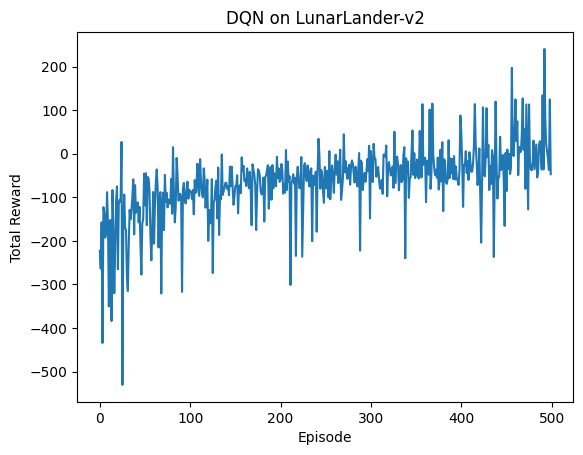

In [13]:
import matplotlib.pyplot as plt

env = gym.make("LunarLander-v3")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQNAgent(env, state_dim, action_dim)

num_episodes = 500
target_update_freq = 10 #updating every 10 episodes, can be changed
reward_history = []

for episode in range(num_episodes):
    state, _ = env.reset() # LunarLander-v3 returns state and info dictionary
    total_reward = 0
    done = False

    while not done:
        action = agent.select_action(state)
        # LunarLander-v3 returns state, reward, terminated, truncated, info
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated # done is True if terminated or truncated
        total_reward += reward

        agent.memory.push((state, action, reward, next_state, done))

        state = next_state

        agent.train_step()

    agent.decay_epsilon()

    if episode % target_update_freq == 0: #update target network every few episodes instead of every episode
        agent.update_target_network()

    reward_history.append(total_reward)
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

plt.plot(reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN on LunarLander-v3")
plt.show()

torch.save(agent.q_network.state_dict(), "lunarlander_dqn.pth")

In [14]:
torch.save(agent.q_network.state_dict(), "lunarlander_dqn.pth")